In [1]:
import pandas as pd
import os
import numpy as np

In [88]:
X_test = pd.read_csv('/content/sample_data/linreg_test.csv', index_col = 0).reset_index(drop = True)
X_train = pd.read_csv('/content/sample_data/linreg_train.csv', index_col = 0).reset_index(drop = True)
Y_train = pd.read_csv('/content/sample_data/linreg_y_train.csv', index_col = 0).reset_index(drop = True)


## Сделаем флаги вместо категориального

In [89]:
X_train.head()

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker
0,Passat,2019,Manual,15435,Diesel,150,51.4,2.0,vw
1,A Class,2019,Semi-Auto,17945,Diesel,145,65.7,1.5,mercedes
2,Focus,2017,Manual,20102,Petrol,20,60.1,1.0,ford
3,C-HR,2018,Automatic,8661,Hybrid,135,74.3,1.8,toyota
4,Fiesta,2020,Manual,10,Petrol,150,58.9,1.0,ford


In [90]:
XX = pd.concat([X_train, X_test], axis = 0)

XX = pd.get_dummies(XX, 
                                  prefix = ['year','fuelType','transmission','model'], 
                                  columns = ['year','fuelType','transmission','model'],       
                                  drop_first = False)

Я не сильно парюсь, что возможно есть model, которые есть в тесте, но нет в обучении: В этом случае на обучении они всегда будут равны 0

In [91]:
X_train.shape, X_test.shape

((64556, 9), (16139, 10))

## Разделим обратно

In [92]:
new_train = XX.iloc[:64556]
new_test = XX.iloc[64556:]

In [93]:
premium = new_train[new_train.car_maker.isin(['mercedes','audi','bmw'])].copy()
standard = new_train[~new_train.car_maker.isin(['mercedes','audi','bmw'])].copy()

y_premium = Y_train[new_train.car_maker.isin(['mercedes','audi','bmw'])].copy()
y_standard = Y_train[~new_train.car_maker.isin(['mercedes','audi','bmw'])].copy()

## Цены вроде отличаются

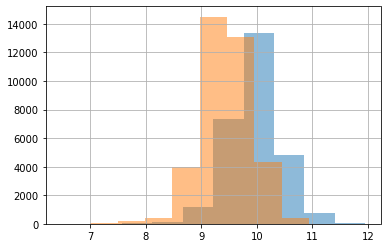

In [94]:
np.log(y_premium.price).hist(alpha = 0.5)
np.log(y_standard.price).hist(alpha = 0.5)

In [95]:
premium['log_price'] = np.log(y_premium.price)
standard['log_price'] = np.log(y_standard.price)

## Доделаем переменных

In [96]:
standard_train = pd.get_dummies(standard, 
                                  prefix = ['car_maker'], 
                                  columns = ['car_maker'],       
                                  drop_first = False)

prem_train = pd.get_dummies(premium, 
                                  prefix = ['car_maker'], 
                                  columns = ['car_maker'],       
                                  drop_first = False)

In [97]:
indices = np.array(new_test.car_maker.isin(['mercedes','audi','bmw']))

In [98]:
new_test_prem = new_test[new_test.car_maker.isin(['mercedes','audi','bmw'])].copy()
new_test_standard = new_test[~new_test.car_maker.isin(['mercedes','audi','bmw'])].copy()

In [99]:
new_test_prem = pd.get_dummies(new_test_prem, 
                                  prefix = ['car_maker'], 
                                  columns = ['car_maker'],       
                                  drop_first = False)

new_test_standard = pd.get_dummies(new_test_standard, 
                                  prefix = ['car_maker'], 
                                  columns = ['car_maker'],       
                                  drop_first = False)

## Шкалируем

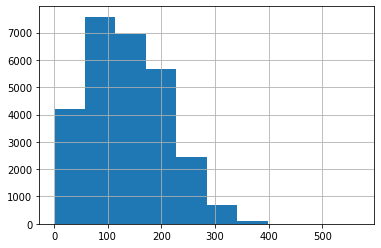

In [100]:
np.sqrt(prem_train['mileage']).hist()

In [101]:
new_test_prem['mileage'] = np.sqrt(new_test_prem['mileage'])
new_test_standard['mileage'] = np.sqrt(new_test_standard['mileage'])

prem_train['mileage'] = np.sqrt(prem_train['mileage'])
standard_train['mileage'] = np.sqrt(standard_train['mileage'])

## Премиум

In [102]:
from sklearn.preprocessing import StandardScaler
f = StandardScaler()
f.fit(prem_train[['mileage','tax','mpg','engineSize']].values)
scaled_features = f.transform(prem_train[['mileage','tax','mpg','engineSize']].values)
scaled_features_df = pd.DataFrame(scaled_features, index = prem_train.index, columns = prem_train[['mileage','tax','mpg','engineSize']].columns)

xx = prem_train.drop(['mileage','tax','mpg','engineSize'], axis = 1)
prem_train = pd.concat([xx, scaled_features_df], axis=1)

In [103]:
scaled_features = f.transform(new_test_prem[['mileage','tax','mpg','engineSize']].values)
scaled_features_df = pd.DataFrame(scaled_features, index = new_test_prem.index, columns = new_test_prem[['mileage','tax','mpg','engineSize']].columns)
xx = new_test_prem.drop(['mileage','tax','mpg','engineSize'], axis = 1)
new_test_prem = pd.concat([xx, scaled_features_df], axis=1)

## Стандарт

In [104]:
f.fit(standard_train[['mileage','tax','mpg','engineSize']].values)
scaled_features = f.transform(standard_train[['mileage','tax','mpg','engineSize']].values)
scaled_features_df = pd.DataFrame(scaled_features, index = standard_train.index, columns = standard_train[['mileage','tax','mpg','engineSize']].columns)
xx = standard_train.drop(['mileage','tax','mpg','engineSize'], axis = 1)
standard_train = pd.concat([xx, scaled_features_df], axis=1)

In [105]:
scaled_features = f.transform(new_test_standard[['mileage','tax','mpg','engineSize']].values)
scaled_features_df = pd.DataFrame(scaled_features, index = new_test_standard.index, columns = new_test_standard[['mileage','tax','mpg','engineSize']].columns)
xx = new_test_standard.drop(['mileage','tax','mpg','engineSize'], axis = 1)
new_test_standard = pd.concat([xx, scaled_features_df], axis=1)

# Обучаем

In [59]:
from sklearn import linear_model, metrics
from sklearn.metrics import mean_absolute_error as mae

In [116]:
f2 = linear_model.Ridge(alpha = 1)
f4 = linear_model.Ridge(alpha = 1)

In [107]:
f2.fit(prem_train.drop(['log_price','id'],axis=1),prem_train['log_price'])
f4.fit(standard_train.drop(['log_price','id'],axis=1),standard_train['log_price'])

LassoCV(cv=5)

In [108]:
premium_y = np.exp(f2.predict(new_test_prem.drop(['id'],axis=1)))
standard_y = np.exp(f4.predict(new_test_standard.drop(['id'],axis=1)))

# Ответы

In [109]:
predicted = pd.DataFrame(np.hstack([premium_y,standard_y]))

In [110]:
predicted.columns = ['price']

In [111]:
predicted['id']= np.int32(np.hstack([new_test_prem['id'],new_test_standard['id']]))

In [112]:
predicted = predicted.sort_values(by='id')

In [113]:
predicted

,price,id
6914,10442.019870,0
0,13560.551105,1
6915,17588.967788,2
1,19289.065827,3
6916,10507.852041,4
...,...,...
6912,22931.718018,16134
6913,23130.188491,16135
16136,9417.115187,16136
16137,15082.910775,16137


In [115]:
predicted.sort_values(by='id').to_csv('answer.csv', index = False)

Финальный показатель MAE на тестовой выборке оказался меньше 1800
